<a href="https://colab.research.google.com/github/ProsperChuks/wine-quality-prediction/blob/main/base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [19]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix
import sklearn.utils
from scipy.special import expit
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier

## Load DataSet

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/Wine Quality Project/winequality-red.csv'

dataframe = pd.read_csv(path, error_bad_lines=False)
dataframe

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## Processing the data

In [5]:
correlation = dataframe.corr()['quality'].drop(['quality'])

columns_to_drop = ['citric acid', 'chlorides',
                   'residual sugar','quality',
                   'free sulfur dioxide',
                   'total sulfur dioxide',
                   'pH', 'sulphates']

scaler = MinMaxScaler()
normalized_df = scaler.fit_transform(dataframe.drop(columns_to_drop, axis=1))
features = pd.DataFrame(normalized_df, columns=dataframe.drop(columns_to_drop, axis=1).columns)
target = dataframe['quality']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=30)
x_test

,fixed acidity,volatile acidity,density,alcohol
1147,0.477876,0.198630,0.510279,0.523077
659,0.221239,0.493151,0.508811,0.400000
871,0.203540,0.301370,0.378120,0.338462
1333,0.398230,0.448630,0.552863,0.184615
1411,0.159292,0.239726,0.457416,0.338462
...,...,...,...,...
72,0.274336,0.390411,0.442731,0.169231
754,0.283186,0.246575,0.476505,0.107692
1059,0.380531,0.246575,0.425110,0.569231
1400,0.292035,0.390411,0.450073,0.230769


## Training the data
using Linear Regression

In [6]:
model = LinearRegression().fit(x_train, y_train)
pred = model.predict(x_test)
model.score(x_test, y_test)

0.32801211414081044

In [7]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, pred)
print('%.3f'%mae, 'MAE')

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('%.3f'%rmse, 'RMSE')

from sklearn.metrics import r2_score
r2 = r2_score(y_test, pred)
print('%.3f'%r2, 'R-Squared')

0.531 MAE
0.672 RMSE
0.328 R-Squared


## Training with classification model

### pre-processing data for classification

In [8]:
print(dataframe['quality'].value_counts())

dataframe['quality'] = dataframe['quality'].replace([3], 4)
dataframe['quality'] = dataframe['quality'].replace([8], 7)
print(dataframe['quality'].value_counts())

dataframe = dataframe.drop('residual sugar', axis=1)
X = dataframe.drop('quality', axis=1)
y = dataframe.quality

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)
y_train.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64
5    681
6    638
7    217
4     63
Name: quality, dtype: int64


5    407
6    390
7    126
4     36
Name: quality, dtype: int64

### training the data

In [9]:
smote = SMOTE(random_state=1)
x_train_balanced, y_balanced = smote.fit_sample(x_train, y_train)

x_train_balanced = pd.DataFrame(x_train_balanced, columns=x_train.columns)
y_balanced = pd.DataFrame(y_balanced, columns=['quality'])

normalized_train = scaler.fit_transform(x_train_balanced)
normalized_train = pd.DataFrame(normalized_train, columns=x_train_balanced.columns)

normalized_test = scaler.fit_transform(x_test)
normalized_test = pd.DataFrame(normalized_test, columns=x_train_balanced.columns)

model = LogisticRegression(C=1).fit(normalized_train, y_balanced)
pred = model.predict(normalized_test)
model.score(normalized_train, y_balanced)

accuracy = accuracy_score(y_test, pred)
print('%.2f'%accuracy, 'Accuracy')

precision = precision_score(y_test, pred, average='micro')
print('%.4f'%precision, 'Precision')

0.40 Accuracy
0.3953 Precision


re-defining model;</br>

pipeline


In [10]:
X = dataframe.drop(['quality'], axis=1)
y = dataframe['quality']

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression(C=1, penalty='l2', solver='lbfgs', l1_ratio=0))
])

_model_2 = GridSearchCV(estimator=pipe, param_grid={
    'model__C': [1,2,3,4,5,6,7,8,9,10],
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__solver': ['lbfgs', 'sag', 'saga', 'liblinear', 'newton-cg'],
    'model__l1_ratio': [0, 1]
}, cv=10)

_model_2.fit(X, y)
pd.DataFrame(_model_2.cv_results_).to_csv('/content/drive/MyDrive/Colab Notebooks/Wine Quality Project/cv_tests_result.csv', index=False)

In [11]:
pred = _model_2.predict(dataframe2.drop(['residual sugar', 'quality'], axis=1))

print('%.2f'%_model_2.score(X, y ), 'Model score')
accuracy = accuracy_score(dataframe2['quality'], pred)
print('%.2f'%accuracy, 'Accuracy')

rmse = np.sqrt(mean_squared_error(dataframe2['quality'], pred))
print('%.3f'%rmse, 'RMSE')

precision = precision_score(dataframe2['quality'], pred, average='micro')
print('%.4f'%precision, 'Precision')

0.61 Model score
0.41 Accuracy
0.992 RMSE
0.4136 Precision


### adding more data

In [12]:
path = '/content/drive/MyDrive/Colab Notebooks/Wine Quality Project/winequality-white.csv'
global dataframe2
dataframe2 = pd.read_csv(path)
dataframe2.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [41]:
drop_columns = ['free sulfur dioxide',
                'total sulfur dioxide',
                'density']

X2 = dataframe2.drop(['residual sugar', 'quality'], axis=1)
y2 = dataframe2['quality']

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.5)
new_train_set_X = X.append(x_train_2)
new_train_set_y = y.append(y_train_2)

new_train_set_X = sklearn.utils.shuffle(new_train_set_X)
new_train_set_y = sklearn.utils.shuffle(new_train_set_y)
new_train_set_X = new_train_set_X.reset_index(drop=True)
new_train_set_y = new_train_set_y.reset_index(drop=True)

# new_train_set_X = new_train_set_X.drop(drop_columns, axis=1)
# x_test_2 = x_test_2.drop(drop_columns, axis=1)
new_train_set_X

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.25,0.29,0.020,31.0,113.0,0.99338,3.13,0.29,10.8
1,6.6,0.45,0.43,0.064,31.0,186.0,0.99540,3.12,0.44,9.4
2,6.7,0.33,0.34,0.036,39.0,124.0,0.99123,2.99,0.32,12.4
3,7.3,0.26,0.32,0.041,29.0,94.0,0.98978,3.07,0.45,12.0
4,7.2,0.21,0.31,0.035,36.0,122.0,0.99478,3.12,0.40,10.6
...,...,...,...,...,...,...,...,...,...,...
7342,6.6,0.35,0.29,0.044,54.0,177.0,0.99910,3.17,0.58,8.9
7343,8.3,0.24,0.27,0.030,22.0,162.0,0.99140,2.99,0.68,11.9
7344,6.8,0.16,0.29,0.046,59.0,143.0,0.99518,3.20,0.40,10.8
7345,7.6,0.30,0.22,0.049,57.0,191.0,0.99660,3.08,0.40,9.3


### result for Log regression

the best parameters extracted to use train the model didn't have good metric score, they had an ok performance on training set, but a bad one on the testing test

## switching to KNN

tuning parameters

In [59]:
x = dataframe2.drop(['residual sugar', 'quality'], axis=1)
y = dataframe2['quality']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=30)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=5, weights='uniform'))
])

_model_3 = GridSearchCV(estimator=pipe, param_grid={
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance']
}, cv=10)

_model_3.fit(x_train, y_train)
pd.DataFrame(_model_3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007333,0.000345,0.028599,0.001943,5,uniform,"{'model__n_neighbors': 5, 'model__weights': 'u...",0.532609,0.538043,0.524457,0.583106,0.504087,0.564033,0.547684,0.555858,0.564033,0.566757,0.548067,0.022313,19
1,0.007115,0.000257,0.018897,0.001567,5,distance,"{'model__n_neighbors': 5, 'model__weights': 'd...",0.644022,0.616848,0.600543,0.673025,0.613079,0.656676,0.640327,0.618529,0.640327,0.643052,0.634643,0.020943,16
2,0.007199,0.000501,0.028460,0.000506,6,uniform,"{'model__n_neighbors': 6, 'model__weights': 'u...",0.565217,0.521739,0.486413,0.580381,0.534060,0.539510,0.512262,0.544959,0.569482,0.569482,0.542351,0.028256,30
3,0.006931,0.000159,0.019402,0.001409,6,distance,"{'model__n_neighbors': 6, 'model__weights': 'd...",0.654891,0.641304,0.589674,0.675749,0.621253,0.673025,0.623978,0.621253,0.645777,0.656676,0.640358,0.025287,15
4,0.007314,0.000593,0.030574,0.002209,7,uniform,"{'model__n_neighbors': 7, 'model__weights': 'u...",0.540761,0.535326,0.529891,0.564033,0.509537,0.550409,0.531335,0.544959,0.555858,0.555858,0.541797,0.015195,32
5,0.007122,0.000493,0.019783,0.001354,7,distance,"{'model__n_neighbors': 7, 'model__weights': 'd...",0.644022,0.635870,0.603261,0.694823,0.615804,0.659401,0.637602,0.615804,0.637602,0.667575,0.641176,0.025873,14
6,0.007065,0.000138,0.030639,0.001427,8,uniform,"{'model__n_neighbors': 8, 'model__weights': 'u...",0.532609,0.543478,0.500000,0.594005,0.531335,0.555858,0.561308,0.569482,0.550409,0.531335,0.546982,0.024350,23
7,0.007183,0.000446,0.020573,0.001050,8,distance,"{'model__n_neighbors': 8, 'model__weights': 'd...",0.652174,0.619565,0.605978,0.692098,0.626703,0.675749,0.648501,0.613079,0.651226,0.643052,0.642813,0.025972,13
8,0.007087,0.000127,0.030423,0.000571,9,uniform,"{'model__n_neighbors': 9, 'model__weights': 'u...",0.513587,0.548913,0.519022,0.585831,0.512262,0.566757,0.547684,0.547684,0.555858,0.523161,0.542076,0.023266,31
9,0.007416,0.000692,0.020956,0.000932,9,distance,"{'model__n_neighbors': 9, 'model__weights': 'd...",0.638587,0.652174,0.614130,0.713896,0.613079,0.675749,0.664850,0.618529,0.651226,0.651226,0.649345,0.029564,11


### metrics

In [60]:
pred = _model_3.predict(x_test)

print('%.2f'%_model_3.score(x_test, y_test), 'Model score')
accuracy = accuracy_score(y_test, pred)
print('%.2f'%accuracy, 'Accuracy')

rmse = np.sqrt(mean_squared_error(y_test, pred))
print('%.3f'%rmse, 'RMSE')

precision = precision_score(y_test, pred, average='micro')
print('%.4f'%precision, 'Precision')

recall = recall_score(y_test, pred, average='micro')
print('%.2f'%recall, 'Recall')

f1 = f1_score(y_test, pred, average='micro')
print('%.2f'%f1, 'F1-score')

0.66 Model score
0.66 Accuracy
0.717 RMSE
0.6580 Precision
0.66 Recall
0.66 F1-score


### confusion matrix

[[  0   0   3   3   0   0   0]
 [  0   7  13  20   1   0   0]
 [  0   0 256 104  13   0   0]
 [  0   0  92 417  41   0   0]
 [  0   0   3  93 108   4   0]
 [  0   0   1  17  10  18   0]
 [  0   0   0   0   1   0   0]]


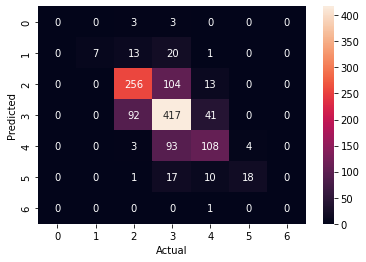

In [61]:
cn_matrix = confusion_matrix(y_test, pred)
print(cn_matrix)
sns.heatmap(cn_matrix, annot=True, fmt='')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()